In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from pprint import pp

from utils import CONFIG

In [77]:
top_k = 50

drop_columns = [
    "device",
    "learning_rate",
    "dataset",
    "batch_size",
    "top_k",
    "seed",
    "Epochs",
    "epochs",
    "model",
    "Loss"
]

if False:
    for k in CONFIG.top_k:
        if k != top_k:
            drop_columns.extend([f"Precision@{k}", f"Recall@{k}", f"NDCG@{k}"])

print(drop_columns)

['device', 'learning_rate', 'dataset', 'batch_size', 'top_k', 'seed', 'Epochs', 'epochs', 'model', 'Loss']


In [97]:
files = os.listdir("logs")
settings = {}

for fname in files:
    with open(f"logs/{fname}", "r", encoding="utf-8") as fin:
        lines = list(fin)
        epochs, loss, *res = lines[-1].strip().split("\t")

        d = json.loads(lines[0])

        d["Epochs"] = int(epochs)
        d["Loss"] = float(loss)

        for i, k in enumerate(CONFIG.top_k):
            precision, recall, ndcg = res[i * 3:(i * 3)+3]
            d[f"Precision@{k}"] = float(precision)
            d[f"Recall@{k}"] = float(recall)
            d[f"NDCG@{k}"] = float(ndcg)

        settings[fname[:-4]] = d

df = pd.DataFrame(settings).T.convert_dtypes()
df = df.drop(columns=drop_columns)
# dbbook full grid search: from 2025-01-09T15:41:18 to 2025-01-09T19:12:27

df.rename(columns={"embedding_dim": "emb_dim"}).sort_index().dropna().sort_values("NDCG@20", ascending=False)

,n_layers,emb_dim,fusion,multimodal,Precision@5,Recall@5,NDCG@5,Precision@10,Recall@10,NDCG@10,Precision@20,Recall@20,NDCG@20,Precision@50,Recall@50,NDCG@50
2025-01-09T16:00:33,0,2048,max,True,0.0829,0.0664,0.0984,0.0631,0.1001,0.0989,0.0467,0.145,0.1166,0.0303,0.231,0.1477
2025-01-09T15:48:40,0,1024,max,True,0.0805,0.0651,0.097,0.062,0.0982,0.0978,0.0465,0.1445,0.1161,0.0306,0.2331,0.1481
2025-01-09T15:45:02,0,512,max,True,0.0804,0.064,0.0946,0.0613,0.0955,0.095,0.046,0.1411,0.1131,0.0301,0.2275,0.1444
2025-01-09T16:04:25,0,2048,mean,True,0.0786,0.063,0.0933,0.0604,0.0961,0.0944,0.0446,0.1384,0.1111,0.0289,0.2192,0.1404
2025-01-09T15:50:54,0,1024,mean,True,0.076,0.0616,0.0911,0.0591,0.0926,0.0921,0.0448,0.1382,0.1102,0.0293,0.222,0.1405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-09T15:41:18,0,64,max,False,0.0522,0.0401,0.0605,0.0427,0.0642,0.0633,0.0339,0.1011,0.0783,0.0234,0.1722,0.1041
2025-01-09T17:49:28,3,64,mean,False,0.0451,0.0342,0.0478,0.0421,0.0625,0.0551,0.0356,0.105,0.0729,0.027,0.1988,0.1068
2025-01-09T17:48:12,3,64,max,False,0.0451,0.0342,0.0478,0.0421,0.0625,0.0551,0.0356,0.105,0.0729,0.027,0.1988,0.1068
2025-01-09T17:50:06,3,64,mean,True,0.0453,0.0322,0.047,0.041,0.0588,0.0529,0.0358,0.1018,0.0711,0.0273,0.1963,0.1054


In [79]:
df.where(
    (df["fusion"] == "max") & (df["embedding_dim"] == 1024) & (df["multimodal"])
).groupby("n_layers")[["Precision@5", "Recall@5", "NDCG@5", "Precision@10", "Recall@10", "NDCG@10", "Precision@20", "Recall@20", "NDCG@20", "Precision@50", "Recall@50", "NDCG@50"]].mean()

,Precision@5,Recall@5,NDCG@5,Precision@10,Recall@10,NDCG@10,Precision@20,Recall@20,NDCG@20,Precision@50,Recall@50,NDCG@50
n_layers,,,,,,,,,,,,
0,0.0805,0.0651,0.097,0.062,0.0982,0.0978,0.0465,0.1445,0.1161,0.0306,0.2331,0.1481
1,0.07,0.057,0.0823,0.0546,0.0881,0.0847,0.0422,0.1327,0.1027,0.0289,0.2234,0.1352
2,0.0726,0.0587,0.0843,0.0574,0.0917,0.0874,0.0443,0.1392,0.1064,0.0301,0.2311,0.1395
3,0.0653,0.0527,0.075,0.0544,0.0862,0.0804,0.0426,0.1345,0.0996,0.0291,0.2249,0.132


In [80]:
file = os.listdir("logs")[-1]
file_path = f"logs/{file}"

with open(file_path, 'r') as f:
    config_line = f.readline().strip()
    config = json.loads(config_line)

data = pd.read_csv(file_path, sep='\t', skiprows=1)

In [81]:
data

,Epoch,Loss,Precision@5,Recall@5,NDCG@5,Precision@10,Recall@10,NDCG@10,Precision@20,Recall@20,NDCG@20,Precision@50,Recall@50,NDCG@50
0,1,0.6803,0.0479,0.0352,0.0544,0.0366,0.0531,0.0540,0.0268,0.0766,0.0633,0.0166,0.1209,0.0792
1,2,0.6347,0.0449,0.0323,0.0469,0.0364,0.0517,0.0490,0.0290,0.0829,0.0617,0.0202,0.1446,0.0843
2,3,0.5589,0.0364,0.0266,0.0354,0.0319,0.0447,0.0394,0.0266,0.0739,0.0518,0.0205,0.1441,0.0774
3,4,0.4597,0.0305,0.0220,0.0293,0.0292,0.0411,0.0349,0.0255,0.0695,0.0474,0.0202,0.1401,0.0734
4,5,0.3679,0.0285,0.0207,0.0273,0.0283,0.0395,0.0333,0.0250,0.0678,0.0458,0.0201,0.1388,0.0719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,0.0138,0.0676,0.0546,0.0767,0.0545,0.0872,0.0810,0.0426,0.1349,0.1002,0.0288,0.2239,0.1320
146,147,0.0142,0.0674,0.0547,0.0766,0.0543,0.0869,0.0809,0.0426,0.1345,0.1001,0.0288,0.2237,0.1319
147,148,0.0133,0.0674,0.0550,0.0768,0.0546,0.0874,0.0812,0.0426,0.1341,0.1001,0.0288,0.2236,0.1320
148,149,0.0137,0.0673,0.0552,0.0768,0.0545,0.0874,0.0811,0.0425,0.1340,0.0999,0.0288,0.2234,0.1318


In [82]:
epochs = data["Epoch"]
loss = data["Loss"]

{'n_layers': 3,
 'device': 'cuda',
 'batch_size': 2048,
 'embedding_dim': 2048,
 'learning_rate': 0.001,
 'dataset': 'dbbook',
 'epochs': 150,
 'model': 'ef-mmlgcn',
 'fusion': 'mean',
 'top_k': [5,
           10,
           20,
           50],
 'seed': 19,
 'multimodal': True}

Epoch           150.0000
Loss              0.0140
Precision@5       0.0672
Recall@5          0.0550
NDCG@5            0.0767
Precision@10      0.0543
Recall@10         0.0870
NDCG@10           0.0810
Precision@20      0.0425
Recall@20         0.1344
NDCG@20           0.1000
Precision@50      0.0288
Recall@50         0.2235
NDCG@50           0.1318
Name: 149, dtype: float64


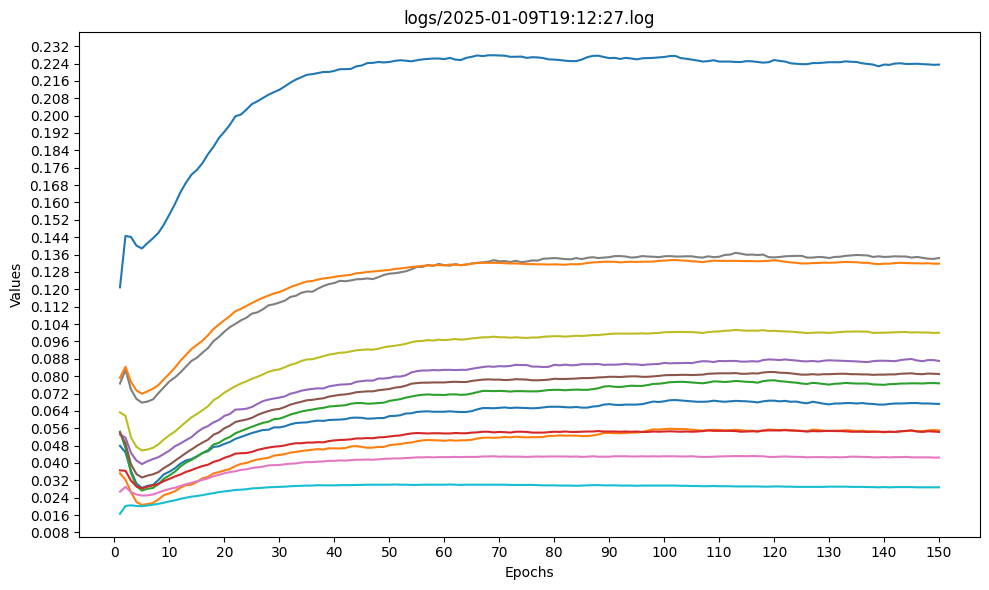

In [83]:
pp(config, width=1)
print()
print(data.iloc[-1])

plt.figure(figsize=(10, 6))

#plt.plot(epochs, loss, label="Loss")

for k in CONFIG.top_k:
    plt.plot(epochs, data[f"Precision@{k}"], label=f"Precision@{k}")
    plt.plot(epochs, data[f"Recall@{k}"], label=f"Recall@{k}")
    plt.plot(epochs, data[f"NDCG@{k}"], label=f"NDCG@{k}")


plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title(file_path)
#plt.legend()

plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=30))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))
#plt.yscale("log")

plt.tight_layout()
plt.show()